<div align="right">
  <img src="https://drive.google.com/uc?export=view&id=1J8JpP65HsHXdpJvhb_sMwn3yROyU832m" height="80" width="200" style="float: right;">
</div>
<h1><b>Data Science and Machine Learning</b></h1>
<h2><b>Clase 27</b>: Introducción aprendizaje profundo (Deep learning)</h2>
<h3><b>Docente</b>: <a href="https://www.linkedin.com/in/danielablanco/">Daniela Blanco</a>

# RNA para clasificación de imágenes - Guía paso a paso

- Comprender un dataset nuevo.
- Modelar los datos utilizando una RNA.
- Analizar los resultados y optimizar el modelo.

## 🌱 Cómo iniciar este proyecto

Sigue las siguientes instrucciones:

1. Crea un nuevo repositorio basado en el [proyecto de Machine Learning](https://github.com/4GeeksAcademy/machine-learning-python-template) o [haciendo clic aquí](https://github.com/4GeeksAcademy/machine-learning-python-template/generate).
2. Abre el repositorio creado recientemente en Codespace usando la [extensión del botón de Codespace](https://docs.github.com/en/codespaces/developing-in-codespaces/creating-a-codespace-for-a-repository#creating-a-codespace-for-a-repository).
3. Una vez que el VSCode del Codespace haya terminado de abrirse, comienza tu proyecto siguiendo las instrucciones a continuación.

## 🚛 Cómo entregar este proyecto

Una vez que hayas terminado de resolver el caso práctico, asegúrate de confirmar tus cambios, haz push a tu repositorio y ve a 4Geeks.com para subir el enlace del repositorio.

## 📝 Instrucciones

### Sistema de clasificación de imágenes

El conjunto de datos se compone de fotos de perros y gatos proporcionadas como un subconjunto de fotos de uno mucho más grande de 3 millones de fotos anotadas manualmente. Estos datos se obtuvieron a través de una colaboración entre Petfinder.com y Microsoft.

El conjunto de datos se usó originalmente como un CAPTCHA, es decir, una tarea que se cree que un humano encuentra trivial, pero que una máquina no puede resolver, que se usa en sitios web para distinguir entre usuarios humanos y bots. La tarea se denominó "Asirra". Cuando se presentó "Asirra", se mencionó "que los estudios de usuarios indican que los humanos pueden resolverlo el 99,6% de las veces en menos de 30 segundos". A menos que se produzca un gran avance en la visión artificial, esperamos que los ordenadores no tengan más de 1/54.000 posibilidades de resolverlo.

En el momento en que se publicó la competencia, el resultado de última generación se logró con un SVM y se describió en un artículo de 2007 con el título "Ataques de Machine Learning contra el CAPTCHA de Asirra" (PDF) que logró una precisión de clasificación del 80%. Fue este documento el que demostró que la tarea ya no era una tarea adecuada para un CAPTCHA poco después de que se propusiera la tarea.

In [ ]:
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

#### Paso 1: Carga del conjunto de datos

El conjunto de datos se encuentra en Kaggle y tendrás que acceder a ella para descargarlos. La competición la puedes encontrar [aquí](https://www.kaggle.com/c/dogs-vs-cats/data) (o copiando y pegando el siguiente enlace en tu navegador: `https://www.kaggle.com/c/dogs-vs-cats/data`)

Descarga la carpeta dataset y descomprime los archivos. Ahora tendrás una carpeta llamada `train` que contiene 25.000 archivos de imagen (formato .jpg) de perros y gatos. Las fotos están etiquetadas por su nombre de archivo, con la palabra `dog` o `cat`.

In [ ]:
# rutas
train_path = 'D:/4geeks/DS/27/train/'
test_path = 'D:/4geeks/DS/27/test/'

#### Paso 2: Visualiza la información de entrada

El primer paso cuando nos enfrentamos a un problema de clasificación de imágenes es obtener toda la información posible a través de ellas. Por lo tanto, carga e imprime las primeras nueve fotos de perros en una sola figura. Repite lo mismo para los gatos. Puedes ver que las fotos son a color y tienen diferentes formas y tamaños.

Esta variedad de tamaños y formatos debe solucionarse antes de entrenar el modelo. Asegúrate de que todas tengan un tamaño fijo de 200x200 píxeles.

In [ ]:
def graficar_muestra(path_directorio, categoria= 'dog', cantidad_ejemplos=9):
    plt.figure(figsize=(10, 10))

    imagenes = []
    etiquetas = []

    etiqueta = 1
    if categoria == "cat":
        etiqueta = 0

    cantidad_procesada = 0
    i = 0
    for imagen in os.listdir(path_directorio):
        if imagen.startswith(categoria):
            imagen_path = os.path.join(path_directorio, imagen)

            imagenes.append(load_img(imagen_path, target_size=(200, 200)))
            etiquetas.append(etiqueta)

            if cantidad_procesada == cantidad_ejemplos:
                break # sale del for

            cantidad_procesada += 1

            plt.subplot(3, 3, i + 1)
            plt.imshow(imagenes[i])
            plt.title(categoria)
            plt.axis('off')

            i += 1
    plt.show()

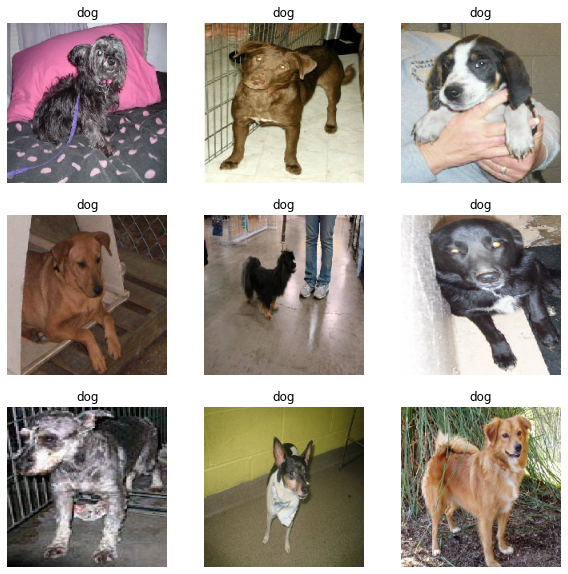

In [ ]:
# si es la ejecucion inicial alcanza con train_path
graficar_muestra(train_path+'dog', 'dog', 9)

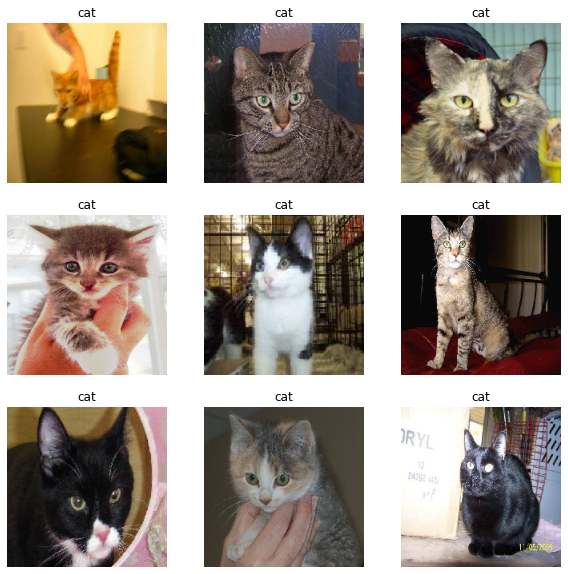

In [ ]:
# si es la ejecucion inicial alcanza con train_path
graficar_muestra(train_path+'cat', 'cat', 9)

Como podrás ver, son una gran cantidad de imágenes, asegúrate de seguir las siguientes normas:

1. **Si tienes más de 12 gigabytes de RAM**, usa la API de procesamiento de imágenes de Keras para cargar las 25.000 fotos en el conjunto de datos de entrenamiento y remodelarlas a fotos cuadradas de 200×200 píxeles. La etiqueta también debe determinarse para cada foto en función de los nombres de archivo. Se debe guardar una tupla de fotos y etiquetas.
2. **Si no tienes más de 12 gigabytes de RAM**, carga las imágenes progresivamente usando la clase Keras `ImageDataGenerator` y la función `flow_from_directory()`. Esto será más lento de ejecutar, pero se ejecutará en hardware de menor capacidad. Esta función prefiere que los datos se dividan en directorios *train* y *test* separados, y debajo de cada directorio para tener un subdirectorio para cada clase.

Una vez tengas todas las imágenes procesadas, crea un objeto `ImageDataGenerator` para datos de entrenamiento y prueba. Luego pasa la carpeta que tiene datos de entrenamiento al objeto `trdata` y, de manera similar, pasa la carpeta que tiene datos de prueba al objeto `tsdata`. De esta forma, se etiquetarán las imágenes automáticamente y estará todo listo para entrar a la red.

**Para usar flow_from_directory se dividen los datos en subcarpetas por clase**

In [ ]:
# mueve imagenes a subcarpetas
def organizar_imagenes(path_directorio):
    # crea nuevas subcarpetas si no existen
    directorio_perros = os.path.join(path_directorio, 'dog')
    directorio_gatos = os.path.join(path_directorio, 'cat')

    os.makedirs(directorio_perros, exist_ok=True)
    os.makedirs(directorio_gatos, exist_ok=True)

    # recorre todas las imagenes de la carpeta principal
    for imagen in os.listdir(path_directorio):
        if (os.path.isfile(os.path.join(path_directorio, imagen))):
            # es un archivo de imagen, no una subcarpeta
            if imagen.startswith('cat'):
                shutil.move(os.path.join(path_directorio, imagen), os.path.join(directorio_gatos, imagen))
            elif imagen.startswith('dog'):
                shutil.move(os.path.join(path_directorio, imagen), os.path.join(directorio_perros, imagen))

def organizar_imagenes_test(path_directorio):
    # crea nuevas subcarpetas si no existen
    directorio_clase = os.path.join(path_directorio, 'test')
    os.makedirs(directorio_clase, exist_ok=True)

    # recorre todas las imagenes de la carpeta principal
    for imagen in os.listdir(path_directorio):
        if (os.path.isfile(os.path.join(path_directorio, imagen))):
            shutil.move(os.path.join(path_directorio, imagen), os.path.join(directorio_clase, imagen))

def carga_preprocesa_imagenes(path_directorio, img_size=(100, 100), batch_size=32, grayscale=False, data_extra = False):
    # Configuración de ImageDataGenerator para el preprocesamiento
    if data_extra:
        datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    if grayscale:
        color_mode = 'grayscale'
    else:
        color_mode = 'rgb'

    # Cargar imágenes desde la carpeta
    generator = datagen.flow_from_directory(
        directory = path_directorio,
        target_size = img_size,
        batch_size = batch_size,
        class_mode ='binary',  # Usamos 'binary' porque tenemos solo dos clases (cat y dog)
        shuffle = True, # mexcla para dar variabilidad
        color_mode = color_mode
    )

    return generator

In [ ]:
# para que funcione flow_from_directory
# mueve train a carpetas por clase
organizar_imagenes(train_path)
# mueve test a subcarpeta test
organizar_imagenes_test(test_path)

img_size=(100, 100)
batch_size = 32
# Cambia a True si quieres convertir las imágenes a escala de grises
grayscale = True

# Cargar y preprocesar imágenes
train_generator = carga_preprocesa_imagenes(train_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale)
test_generator = carga_preprocesa_imagenes(test_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


#### Paso 3: Construye una RNA

Cualquier clasificador que se ajuste a este problema tendrá que ser robusto porque algunas imágenes muestran al gato o al perro en una esquina o tal vez a 2 gatos o perros en la misma foto. Si has podido investigar algunas de las implementaciones de los ganadores de otras competiciones también relacionadas con imágenes, verás que `VGG16` es una arquitectura de CNN utilizada para ganar la competencia de Kaggle ILSVR (Imagenet) en 2014. Se considera una de las arquitecturas de modelos de visión con mejores resultados hasta la fecha.

Utiliza la siguiente arquitectura de prueba:

```py
model = Sequential()
model.add(Conv2D(input_shape = (224,224,3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))
```

El código anterior aplica convoluciones a los datos (capas `Conv2D` y `MaxPool2D`) y después aplica capas densas (capas `Dense`) para el procesamiento de los valores numéricos obtenidos tras las convoluciones.

A continuación añade los elementos restantes para conformar el modelo, entrénalo y mide su rendimiento.

### Experimento 1: Arquitectura propuesta (ver memoria)

In [ ]:
# tamaños iniciales
ancho = img_size[0]
alto = img_size[1]
colores = 3
if grayscale:
    colores = 1


model = Sequential()
model.add(Conv2D(input_shape = (ancho, alto, colores), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 1, activation = "sigmoid")) # ojo lo propuesto no es binario

In [ ]:
# Compilar el modelo antes del entrenamiento
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

In [ ]:
# Entrenar el modelo
# batch_size=32 no es necesario lo maneja el generador
model.fit(train_generator,
          # validation_data= val_generator => se puede dividir el train en dos para tener validacion
          epochs = 5
)

## Experimento 2: Denso

In [ ]:
# tamaños iniciales
ancho = img_size[0]
alto = img_size[1]
colores = 3
if grayscale:
    colores = 1

model_dense = Sequential()
model_dense.add(Flatten(input_shape = (ancho, alto, colores)))
model_dense.add(Dense(units = 150,activation = "relu"))
model_dense.add(Dense(units = 150,activation = "relu"))
model_dense.add(Dense(units = 1, activation = "sigmoid"))

In [ ]:
model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 150)               1500150   
                                                                 
 dense_1 (Dense)             (None, 150)               22650     
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 1,522,951
Trainable params: 1,522,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilar el modelo antes del entrenamiento
model_dense.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

In [ ]:
# Entrenar el modelo
# batch_size=32 no es necesario lo maneja el generador
history_dense = model_dense.fit(train_generator,
          # validation_data= val_generator => se puede dividir el train en dos para tener validacion
          epochs = 10
)

Epoch 1/10
782/782 [==============================] - 38s 48ms/step - loss: 0.6612 - accuracy: 0.6023
Epoch 2/10
782/782 [==============================] - 38s 49ms/step - loss: 0.6631 - accuracy: 0.6016
Epoch 3/10
782/782 [==============================] - 38s 49ms/step - loss: 0.6621 - accuracy: 0.6014
Epoch 4/10
782/782 [==============================] - 39s 49ms/step - loss: 0.6596 - accuracy: 0.6050
Epoch 5/10
782/782 [==============================] - 40s 51ms/step - loss: 0.6591 - accuracy: 0.6072
Epoch 6/10
782/782 [==============================] - 39s 50ms/step - loss: 0.6585 - accuracy: 0.6058
Epoch 7/10
782/782 [==============================] - 39s 50ms/step - loss: 0.6576 - accuracy: 0.6104
Epoch 8/10
782/782 [==============================] - 39s 50ms/step - loss: 0.6559 - accuracy: 0.6115
Epoch 9/10
782/782 [==============================] - 39s 49ms/step - loss: 0.6557 - accuracy: 0.6136
Epoch 10/10
782/782 [==============================] - 38s 49ms/step - loss: 0.653

El número de pasos por época (steps_per_epoch) se calcula dividiendo el número total de imágenes por el tamaño del lote:
25000 / 32 = 781.25

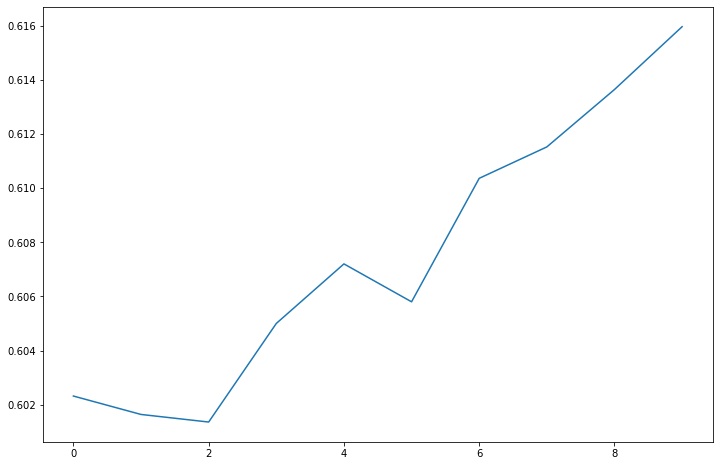

In [ ]:
accuracy = history_dense.history['accuracy']

plt.figure(figsize=(5, 5))
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.show()

## Experimento 3: Convolucional

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

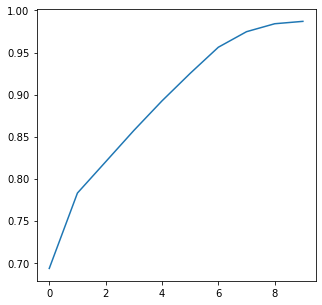

In [ ]:
# tamaños iniciales
ancho = img_size[0]
alto = img_size[1]
colores = 3
if grayscale:
    colores = 1

model_cnn = Sequential()
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(ancho, alto, colores)))
model_cnn.add(MaxPool2D(pool_size = (2,2)))
model_cnn.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model_cnn.add(MaxPool2D(pool_size = (2,2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(units = 128,activation = "relu"))
model_cnn.add(Dense(units = 1, activation = "sigmoid"))

model_cnn.summary()

# Compilar el modelo antes del entrenamiento
model_cnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

# Entrenar el modelo
# batch_size=32 no es necesario lo maneja el generador
history_cnn = model_cnn.fit(train_generator,
          # validation_data= val_generator => se puede dividir el train en dos para tener validacion
          epochs = 10
)

accuracy = history_cnn.history['accuracy']

plt.figure(figsize=(5, 5))
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.show()

## Experimento 4: Convolucional + data augmentation

In [ ]:
# para que funcione flow_from_directory
# mueve train a carpetas por clase
organizar_imagenes(train_path)
# mueve test a subcarpeta test
organizar_imagenes_test(test_path)

img_size=(100, 100)
batch_size = 32
# Cambia a True si quieres convertir las imágenes a escala de grises
grayscale = True
data_extra = True

# Cargar y preprocesar imágenes
train_generator = carga_preprocesa_imagenes(train_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale, data_extra = data_extra)
test_generator = carga_preprocesa_imagenes(test_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale, data_extra = data_extra)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 49, 49, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 36864)             0         
                                                                 
 dense_17 (Dense)            (None, 128)              

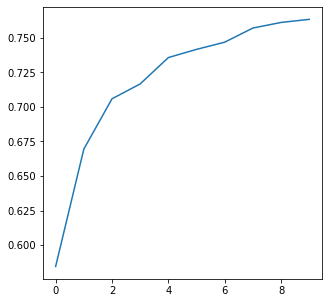

In [ ]:
# tamaños iniciales
ancho = img_size[0]
alto = img_size[1]
colores = 3
if grayscale:
    colores = 1

model_cnn_aug = Sequential()
model_cnn_aug.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(ancho, alto, colores)))
model_cnn_aug.add(MaxPool2D(pool_size = (2,2)))
model_cnn_aug.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model_cnn_aug.add(MaxPool2D(pool_size = (2,2)))
model_cnn_aug.add(Flatten())
model_cnn_aug.add(Dense(units = 128,activation = "relu"))
model_cnn_aug.add(Dense(units = 1, activation = "sigmoid"))

model_cnn_aug.summary()

# Compilar el modelo antes del entrenamiento
model_cnn_aug.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

# Entrenar el modelo
# batch_size=32 no es necesario lo maneja el generador
history_cnn_aug = model_cnn_aug.fit(train_generator,
          # validation_data= val_generator => se puede dividir el train en dos para tener validacion
          epochs = 10
)

accuracy = history_cnn_aug.history['accuracy']

plt.figure(figsize=(5, 5))
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.show()

## Experimento 5: Convolucional + data augmentation + Dropout + Early stoping + checkpoint

In [ ]:
# para que funcione flow_from_directory
# mueve train a carpetas por clase
organizar_imagenes(train_path)
# mueve test a subcarpeta test
organizar_imagenes_test(test_path)

img_size=(100, 100)
batch_size = 32
# Cambia a True si quieres convertir las imágenes a escala de grises
grayscale = True
data_extra = True

# Cargar y preprocesar imágenes
train_generator = carga_preprocesa_imagenes(train_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale, data_extra = data_extra)
test_generator = carga_preprocesa_imagenes(test_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale, data_extra = data_extra)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 49, 49, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)       

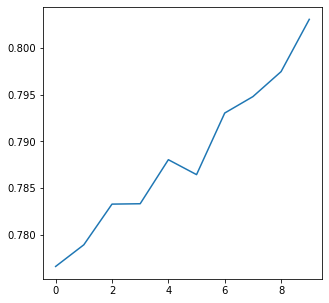

In [ ]:
# tamaños iniciales
ancho = img_size[0]
alto = img_size[1]
colores = 3
if grayscale:
    colores = 1

model_full = Sequential()
model_full.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(ancho, alto, colores)))
model_full.add(MaxPool2D(pool_size = (2,2)))
model_full.add(Dropout(0.20))
model_full.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model_full.add(MaxPool2D(pool_size = (2,2)))
model_full.add(Dropout(0.20))
model_full.add(Flatten())
model_full.add(Dense(units = 128,activation = "relu"))
model_full.add(Dense(units = 1, activation = "sigmoid"))

model_full.summary()

# Compilar el modelo antes del entrenamiento
model_full.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True)

# Entrenar el modelo
# batch_size=32 no es necesario lo maneja el generador
model_full = model_cnn_aug.fit(train_generator,
        # validation_data= val_generator => se puede dividir el train en dos para tener validacion
        epochs = 10 ,
        callbacks=[early_stopping, model_checkpoint]
)

accuracy = model_full.history['accuracy']

plt.figure(figsize=(5, 5))
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.show()

#### Paso 4: Optimiza el modelo anterior

Importa el método `ModelCheckpoint` y `EarlyStopping` de Keras. Crea un objeto de ambos y pásalo como funciones callback a `fit_generator`.

**Ver experimento 5**

#### Paso 5: Predicciones y guardar el modelo

Almacena el modelo en la carpeta correspondiente.

Carga el mejor modelo de los anteriores y utiliza el conjunto de test para hacer predicciones.

**Usamos el modelo del experimento 3**

In [ ]:
# para que funcione flow_from_directory
# mueve train a carpetas por clase
organizar_imagenes(train_path)
# mueve test a subcarpeta test
organizar_imagenes_test(test_path)

img_size=(100, 100)
batch_size = 32
# Cambia a True si quieres convertir las imágenes a escala de grises
grayscale = True
data_extra = False

# Cargar y preprocesar imágenes
train_generator = carga_preprocesa_imagenes(train_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale, data_extra = data_extra)
test_generator = carga_preprocesa_imagenes(test_path, img_size = img_size, batch_size=batch_size, grayscale=grayscale, data_extra = data_extra)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 49, 49, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 36864)             0         
                                                                 
 dense_19 (Dense)            (None, 128)              

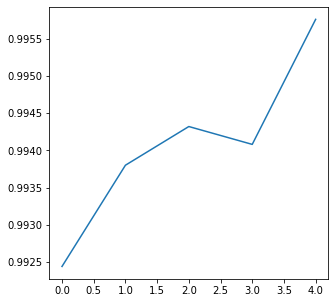

In [ ]:
# tamaños iniciales
ancho = img_size[0]
alto = img_size[1]
colores = 3
if grayscale:
    colores = 1

model_predict = Sequential()
model_predict.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(ancho, alto, colores)))
model_predict.add(MaxPool2D(pool_size = (2,2)))
model_predict.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model_predict.add(MaxPool2D(pool_size = (2,2)))
model_predict.add(Flatten())
model_predict.add(Dense(units = 128,activation = "relu"))
model_predict.add(Dense(units = 1, activation = "sigmoid"))

model_predict.summary()

# Compilar el modelo antes del entrenamiento
model_predict.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
# batch_size=32 no es necesario lo maneja el generador
model_predict = model_cnn.fit(train_generator,
        validation_data= test_generator,
        epochs = 10,
        callbacks= [early_stopping, model_checkpoint]
)

accuracy = model_predict.history['accuracy']

plt.figure(figsize=(5, 5))
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.show()

1/1 [==============================] - 0s 401ms/step
cat


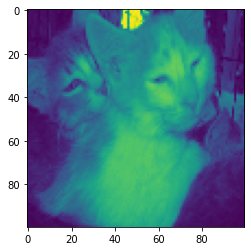

In [ ]:
# predicción
saved_model = load_model("best_model.h5")


archivo = '16.jpg' ##elegir indice

img = load_img(test_path+'/test/'+archivo, target_size = img_size)

# Convertir la imagen a escala de grises
img = img.convert('L')

img = np.asarray(img)

plt.imshow(img)
img = np.expand_dims(img, axis = 0)

prediction = saved_model.predict(img)

if np.argmax(prediction[0]) == 0:
    print("cat")
else:
    print("dog")

## Anexo uso de GPU

Se puede usar de guia este [video](https://www.youtube.com/watch?v=C1en3qSs39g)

## Control instalación

In [ ]:
# Verificar la versión de TensorFlow
print("TensorFlow version:", tf.__version__)

# Verificar el número de GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

In [ ]:
from tensorflow.python.client import device_lib

print('TensorFlow Version: {}'.format(tf.__version__))
print('GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))
print('CUDA Version: {}'.format(tf.sysconfig.get_build_info()['cuda_version']))
print('cuDNN Version: {}\n'.format(tf.sysconfig.get_build_info()['cudnn_version']))

## Control versiones

Ver versiones compatibles para python, cudNN y CUDA en este [link para windows](https://www.tensorflow.org/install/source_windows?hl=es-419) o según SO.


In [ ]:
print("TensorFlow version:", tf.__version__)

In [ ]:
import sys

print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

- CUDA: en terminal nvcc --version (11.2)
- CUDNN:

Buscar el Archivo cudnn_version.h

Navega al directorio de instalación de cuDNN. Por defecto, suele estar en C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\vX.X\include.

Abre el archivo cudnn_version.h con un editor de texto. Busca una línea similar a:

Actualmente para Windows:

| Versión               | Versión de Python | Compilador | herramientas de construcción | cuDNN | CUDA |
|-----------------------|-------------------|------------|------------------------------|-------|------|
| tensorflow_gpu-2.10.0 | 3.7-3.10          | MSVC 2019  | Bazel 5.1.1                  | 8.1   | 11.2 |

## Instalar los Controladores de la GPU

Instala los controladores de NVIDIA:

- En Linux, puedes instalar los controladores utilizando el gestor de paquetes (apt, yum, etc.).
- En Windows, descarga e instala los controladores desde el sitio web de NVIDIA.

Verifica la instalación:

- Ejecuta nvidia-smi en la terminal para verificar que los controladores estén correctamente instalados.

## Instalar CUDA Toolkit y cuDNN

1. CUDA Toolkit:

1.1. Descarga e instala el CUDA Toolkit desde la página oficial de [NVIDIA](https://developer.nvidia.com/cuda-downloads) o [versiones anteriores](https://developer.nvidia.com/cuda-toolkit-archive).

1.2. Añade las rutas de CUDA a las variables de entorno de tu sistema (PATH y LD_LIBRARY_PATH).

Dependiendo del sistema operativo, se realiza de la siguiente manera:

- En Windows

    Abrir el Panel de Control:
    
    Ve a Sistema > Información > Configuración avanzada del sistema.
    
    Haz clic en Variables de entorno.
    
    Editar la Variable Path:
        En la sección de Variables de usuario, selecciona la variable Path y haz clic en Editar.
        Añade las rutas a las carpetas bin y lib64 de CUDA:
            C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\vX.X\bin
            C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\vX.X\libnvvp
        También podrías necesitar añadir:
            C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\vX.X\include
        Haz clic en Aceptar para guardar los cambios.

- En Linux

    Abrir el archivo de configuración de la shell:
        Edita el archivo ~/.bashrc, ~/.zshrc, o el archivo de configuración de la shell que estés utilizando.
    Añadir las rutas:
        Añade las siguientes líneas al final del archivo:
            export PATH=/usr/local/cuda-X.X/bin${PATH:+:${PATH}}
            export LD_LIBRARY_PATH=/usr/local/cuda-X.X/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}
        Reemplaza X.X con la versión específica de CUDA que instalaste.
    Actualizar las variables de entorno:
        Guarda los cambios y ejecuta:
            source ~/.bashrc
        Esto cargará las nuevas variables de entorno en la sesión actual de la terminal.

2. cuDNN Library:

- Descarga cuDNN desde el sitio oficial de [NVIDIA](https://developer.nvidia.com/cudnn) o archivo [NVIDIA](https://developer.nvidia.com/cuda-toolkit-archivey).
- Descomprimir archivo en instalacion cuda

    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2

## Instalar TensorFlow con Soporte para GPU

1. Crea un entorno virtual (opcional pero recomendado):

    python -m venv tf-gpu
    source tf-gpu/bin/activate  # Linux/macOS
    
    o
    
    .\tf-gpu\Scripts\activate  # Windows
    

2. Instala TensorFlow con soporte para GPU:

    pip install tensorflow-gpu